In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%pip install pillow 
# animation saving

import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

import solver as solve # solver
import objective as obj # objective function
import helper as help # helper functions
import parameters as param # parameters
from model import WormModel # worm model

# contraction engine
from contraction import ContractionEngine_segmentdriven
import contraction as contract

importlib.reload(obj)
importlib.reload(help)
importlib.reload(param)
importlib.reload(contract)

Note: you may need to restart the kernel to use updated packages.


<module 'contraction' from 'c:\\Users\\natha\\Desktop\\UCLA\\_Grad\\2025-2026\\FALL 2025\\MAE 263F\\MAE-263F\\final_report\\contraction.py'>

Single Worm Test

In [4]:
worm1 = WormModel(name ="worm1", length=param.length, n_segments=1, fixedDOFs=[ 1, 7])
#worm1.plot()
# print('freeIndex: ', worm1.freeIndex)
# print('fixedIndex: ', worm1.fixedIndex)
# print('ndof: ', worm1.ndof)
# print('q0: ', worm1.q0)

#frames, times = solve.solver(worm1, dt=param.dt, maxTime=2.0, tol=1e-7, maximum_iter=100)
#ani = worm1.animate_worm(frames, times)


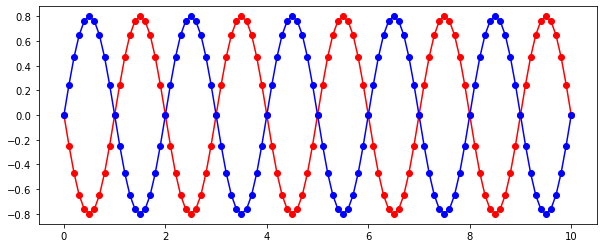

In [5]:
dt = 0.1 # Time step size
maxTime = 10   # total time of simulation
t = np.arange(0, maxTime + dt, dt)

F_history = np.zeros((len(t), worm1.ndof))
for i, time in enumerate(t):
	F_history[i]  = contract.getContract_single_segment(worm1, time)

figure, ax = plt.subplots(figsize=(10, 4))
ax.plot(t , F_history[:, 3], 'o-', color='red')
ax.plot(t , F_history[:, 5], 'o-', color='blue')

# Worm Standing Wave Contraction Test

In [6]:
# 0,1, 2,3, 4,5, 6,7, 8,9 10,11 12,13, 14,15
worm6 = WormModel(name ="worm6", length=param.length, n_segments=param.n, fixedDOFs=[ 1,7,13,19,25,31,37])

## Solver w/o predictor corrector

In [7]:
print("Number of nodes (nv): ", worm6.nv)
print("Number of edges (ne): ", worm6.ne)
print("Number of DOFs (ndof): ", worm6.ndof)
#print(worm6.mMat[0,0], worm6.c[0,0])
#print("Initial position vector: ", worm6.q0)
#print("Initial velocity vector: ", worm6.u0)
#worm6.plot()

# frames, times = solve.solver(worm6, dt=param.dt, maxTime=10, tol=1e-6, maximum_iter=100, contractType='multiple_segments')
# ani = worm6.animate_worm(frames, times)
# print(frames[0])
# print(times)
# print(len(frames))
# print(len(times))
# print(len(frames[0]))


Number of nodes (nv):  19
Number of edges (ne):  30
Number of DOFs (ndof):  38


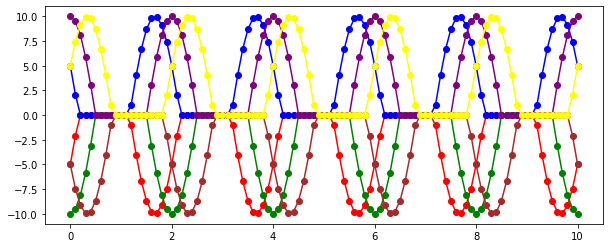

In [8]:
dt = 0.1 # Time step size
maxTime = 10   # total time of simulation
t = np.arange(0, maxTime + dt, dt)

F_history = np.zeros((len(t), worm6.ndof))
for i, time in enumerate(t):
	F_history[i]  = contract.getContract(worm6, time)

figure, ax = plt.subplots(figsize=(10, 4))
ax.plot(t , F_history[:, 3], 'o-', color='red')
ax.plot(t , F_history[:, 5], 'o-', color='blue')
ax.plot(t , F_history[:, 9], 'o-', color='green')
ax.plot(t , F_history[:, 11], 'o-', color='purple')
ax.plot(t , F_history[:, 15], 'o-', color='brown')
ax.plot(t , F_history[:, 17], 'o-', color='yellow')

## Solver with predictor corrector

Ground Position:  -0.09216878364870322


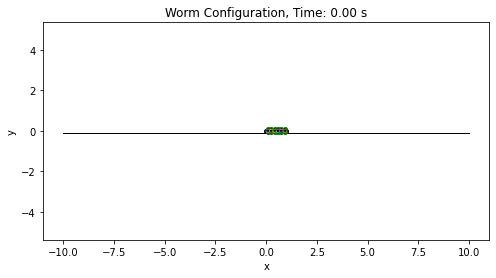

Node 5 hit ground at y=-0.0981
Contact changed - running corrector...
Node 8 hit ground at y=-0.0924
Contact changed - running corrector...
Node 5 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 11 hit ground at y=-0.0922
Contact changed - running corrector...
Node 8 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 14 hit ground at y=-0.0925
Contact changed - running corrector...
Node 11 lifting off, f_y=0.2840
Contact changed - running corrector...


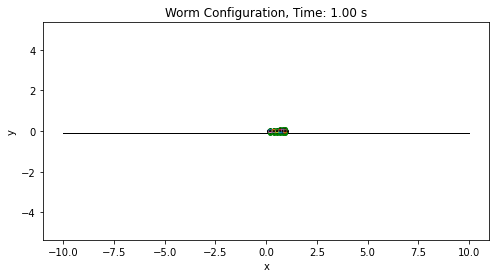

Node 17 hit ground at y=-0.0924
Contact changed - running corrector...
Node 14 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 2 hit ground at y=-0.0922
Contact changed - running corrector...
Node 17 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 5 hit ground at y=-0.0925
Contact changed - running corrector...
Node 2 lifting off, f_y=0.2840
Contact changed - running corrector...


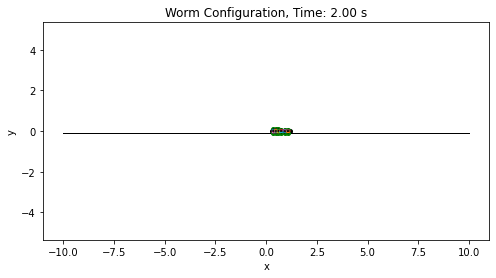

Node 8 hit ground at y=-0.0924
Contact changed - running corrector...
Node 5 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 11 hit ground at y=-0.0922
Contact changed - running corrector...
Node 8 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 14 hit ground at y=-0.0925
Contact changed - running corrector...
Node 11 lifting off, f_y=0.2840
Contact changed - running corrector...


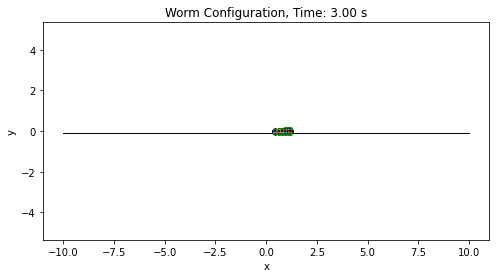

Node 17 hit ground at y=-0.0924
Contact changed - running corrector...
Node 14 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 2 hit ground at y=-0.0922
Contact changed - running corrector...
Node 17 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 5 hit ground at y=-0.0925
Contact changed - running corrector...
Node 2 lifting off, f_y=0.2840
Contact changed - running corrector...


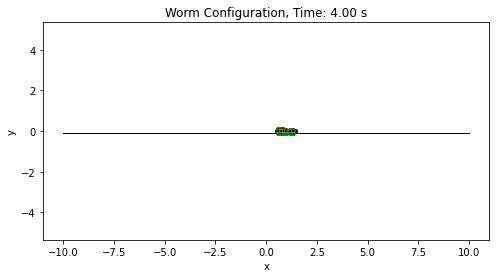

Node 8 hit ground at y=-0.0924
Contact changed - running corrector...
Node 5 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 11 hit ground at y=-0.0922
Contact changed - running corrector...
Node 8 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 14 hit ground at y=-0.0925
Contact changed - running corrector...
Node 11 lifting off, f_y=0.2840
Contact changed - running corrector...


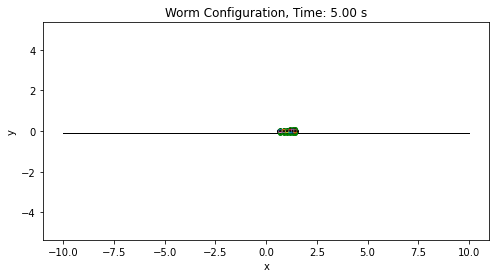

Node 17 hit ground at y=-0.0924
Contact changed - running corrector...
Node 14 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 2 hit ground at y=-0.0922
Contact changed - running corrector...
Node 17 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 5 hit ground at y=-0.0925
Contact changed - running corrector...
Node 2 lifting off, f_y=0.2840
Contact changed - running corrector...


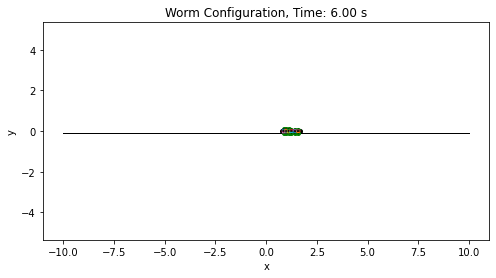

Node 8 hit ground at y=-0.0924
Contact changed - running corrector...
Node 5 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 11 hit ground at y=-0.0922
Contact changed - running corrector...
Node 8 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 14 hit ground at y=-0.0925
Contact changed - running corrector...
Node 11 lifting off, f_y=0.2840
Contact changed - running corrector...


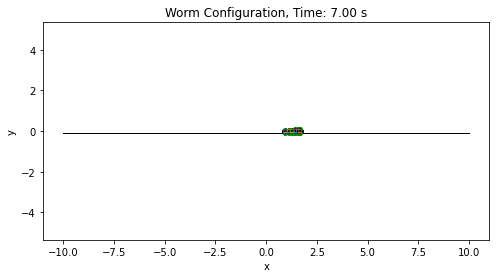

Node 17 hit ground at y=-0.0924
Contact changed - running corrector...
Node 14 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 2 hit ground at y=-0.0922
Contact changed - running corrector...
Node 17 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 5 hit ground at y=-0.0925
Contact changed - running corrector...
Node 2 lifting off, f_y=0.2840
Contact changed - running corrector...


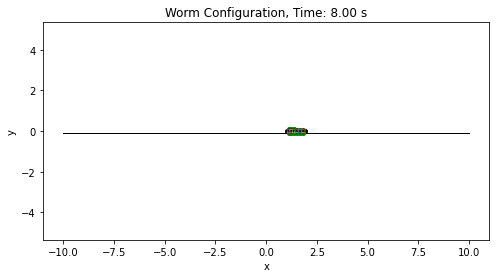

Node 8 hit ground at y=-0.0924
Contact changed - running corrector...
Node 5 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 11 hit ground at y=-0.0922
Contact changed - running corrector...
Node 8 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 14 hit ground at y=-0.0925
Contact changed - running corrector...
Node 11 lifting off, f_y=0.2840
Contact changed - running corrector...


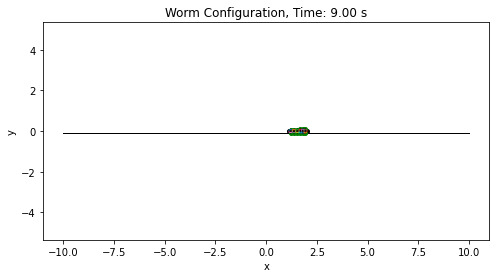

Node 17 hit ground at y=-0.0924
Contact changed - running corrector...
Node 14 lifting off, f_y=0.1073
Contact changed - running corrector...
Node 2 hit ground at y=-0.0922
Contact changed - running corrector...
Node 17 lifting off, f_y=0.4618
Contact changed - running corrector...
Node 5 hit ground at y=-0.0925
Contact changed - running corrector...
Node 2 lifting off, f_y=0.2840
Contact changed - running corrector...


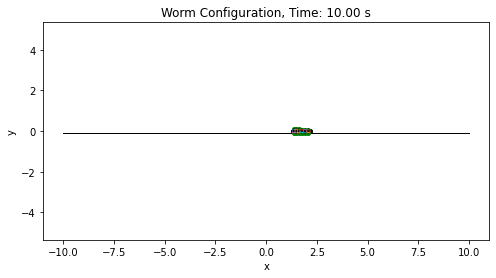

Animation: 1000 total frames → 199 output frames
Playback: 9.99s sim time at 1.0x speed = 9.99s GIF
Animation saved to animations\worm6(2).gif


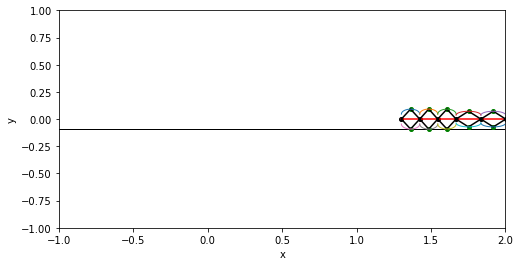

In [28]:
print('Ground Position: ', worm6.groundPosition)
frames, times = solve.solver_with_predictor_corrector(worm6, dt=param.dt, maxTime=10, tol=1e-6, maximum_iter=100, contractType='multiple_segments')
ani = worm6.animate_worm(frames, times)

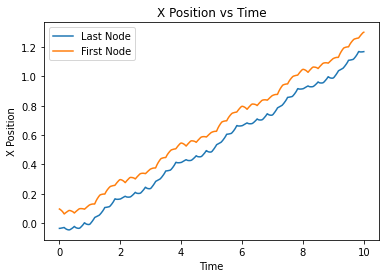

In [29]:
first_node = [frame[0] for frame in frames]
first_node_xpos = [node[0] for node in first_node]

last_node = [frame[-1] for frame in frames]
last_node_xpos = [node[0] for node in last_node]
last_node_xpos = [x - param.length for x in last_node_xpos]

plt.plot(times, last_node_xpos, label='Last Node')
plt.plot(times, first_node_xpos, label='First Node')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.title('X Position vs Time')
plt.legend()
plt.show()